# Imports and constants

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from Metrics import compute_metrics, make_metric_plots
import visualizer.Viewer as vw
from models.time_series.anomaly.statistical.TimeSeriesAnomalyES import TimeSeriesAnomalyES
from reader.NABTimeSeriesReader import NABTimeSeriesReader

# DATASET 1: ambient_temperature_system_failure
# DATASET 2: nyc_taxi
DATASET_PATH = "data/dataset/"
DATASET = "nyc_taxi.csv"
PURE_DATA_KEY = "realKnownCause/nyc_taxi.csv"
GROUND_WINDOWS_PATH = "data/dataset/combined_windows.json"
CHECK_OVERFITTING = False
ALL_DATA = False

def preprocess(X) -> np.ndarray:
    return StandardScaler().fit_transform(X)

# Read the dataset and train-test split

In [5]:
reader = NABTimeSeriesReader(DATASET_PATH)
all_df = reader.read(DATASET_PATH + DATASET).get_dataframe()
training, test = reader.train_test_split(train_perc=0.37).get_train_test_dataframes()

# Data used to train
data = preprocess(np.array(training["value"]).reshape((training["value"].shape[0], 1)))
data_labels = training["target"]

# Data used to test
data_test = preprocess(np.array(test["value"]).reshape((test["value"].shape[0], 1)))
data_test_labels = test["target"]

# Dataframe used to evaluate
dataframe = test.copy()
dataframe["value"] = data_test

train = data

if CHECK_OVERFITTING:
    data_test = data
    data_test_labels = data_labels
    dataframe = training.copy()
    dataframe["value"] = data_test
elif ALL_DATA:
    data_test = preprocess(np.array(all_df["value"]).reshape(all_df["value"].shape[0], 1))
    data_test_labels = all_df["target"]
    dataframe = all_df.copy()
    dataframe["value"] = data_test

# Create model, classify and score

In [6]:
model = TimeSeriesAnomalyES(es_params={"endog": train,
                                       "trend": "add",
                                       "damped_trend": True,
                                       "seasonal": "add",
                                       "seasonal_periods": 7})
model.fit(fit_params={"optimized": True})

true_labels = data_test_labels

labels = model.classify(data_test.reshape((-1, 1)))
scores = model.anomaly_score(data_test.reshape((-1, 1)))

= Start of the model fit =
[2022/05/17 14:35:05] Execution: Start to learn the parameters
[2022/05/17 14:35:06] Execution: Parameters have been learnt
[2022/05/17 14:35:06] Execution: Start to compute predictions of the test set
[2022/05/17 14:35:06] Execution: Test set has been predicted
[2022/05/17 14:35:06] Execution: Start to compute prediction errors
[2022/05/17 14:35:06] Execution: Prediction errors have been computed
[2022/05/17 14:35:06] Execution: Start to compute the threshold on the validation data
[2022/05/17 14:35:06] Execution: Threshold has been computed
[2022/05/17 14:35:06] Execution: The model has been trained and the results are: 
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 3819
Model:             ExponentialSmoothing   SSE                            129.991
Optimized:                        False   AIC                         -12885.288
Trend:            

# Evaluation metrics for anomaly detection

In [7]:
compute_metrics(true_labels, scores, labels, only_roc_auc=False)

ACCURACY SCORE:  0.9910782956468236
PRECISION SCORE:  0.01818181818181818
RECALL SCORE:  0.2
F1 SCORE:  0.03333333333333333
AVERAGE PRECISION SCORE:  0.022898429612580158
PRECISION-RECALL AUC SCORE:  0.011682821208918785
AUROC SCORE:  0.4970443349753695


# Confusion matrix

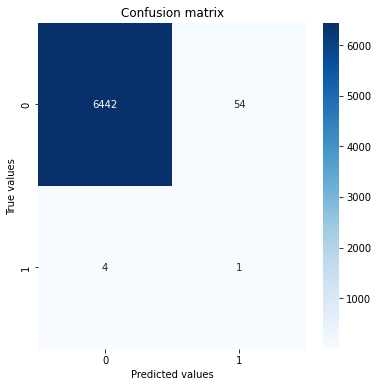

In [8]:
confusion_matrix = metrics.confusion_matrix(true_labels, labels)
vw.plot_confusion_matrix(confusion_matrix)

# ROC curve

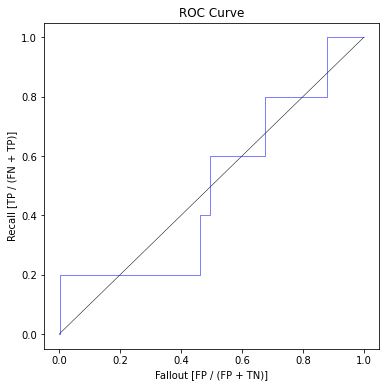

In [9]:
vw.plot_roc_curve(true_labels, scores)

# Precision-recall curve

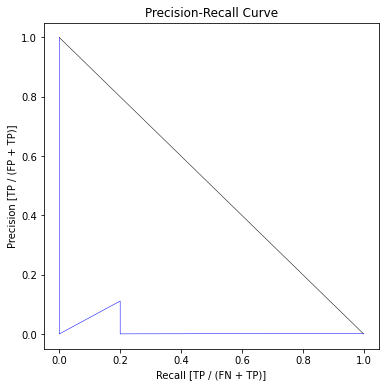

In [10]:
vw.plot_precision_recall_curve(true_labels, scores)

# Assigned labels

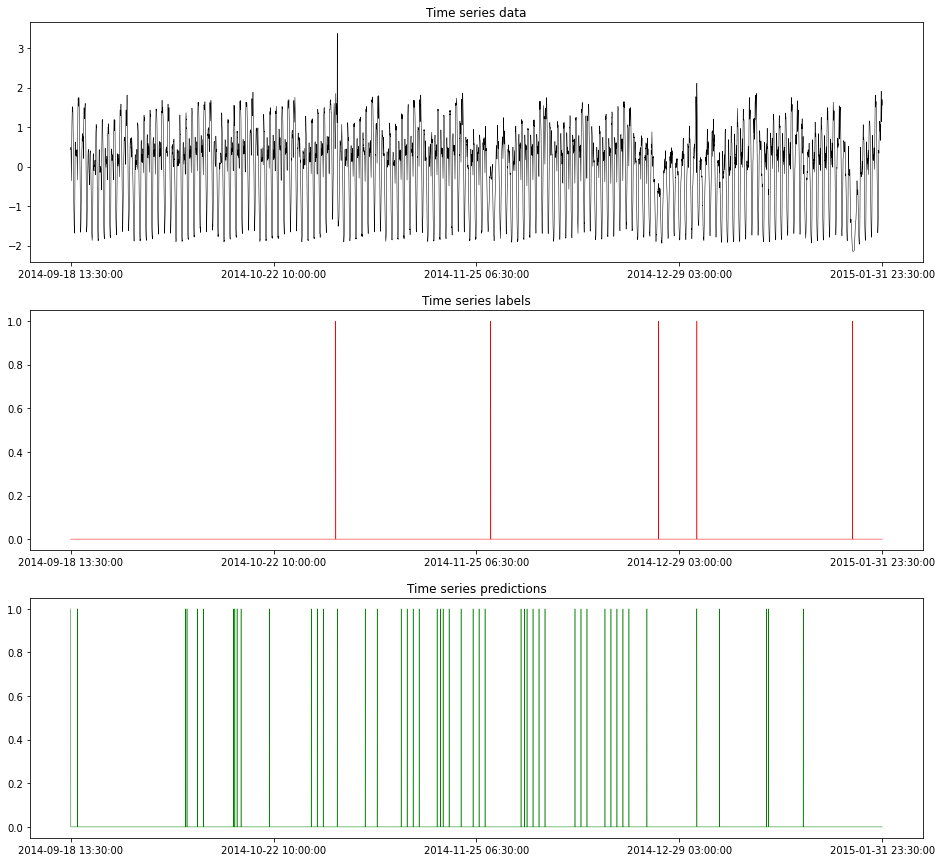

In [11]:
vw.plot_univariate_time_series_predictions(dataframe, labels)

# Assigned scores

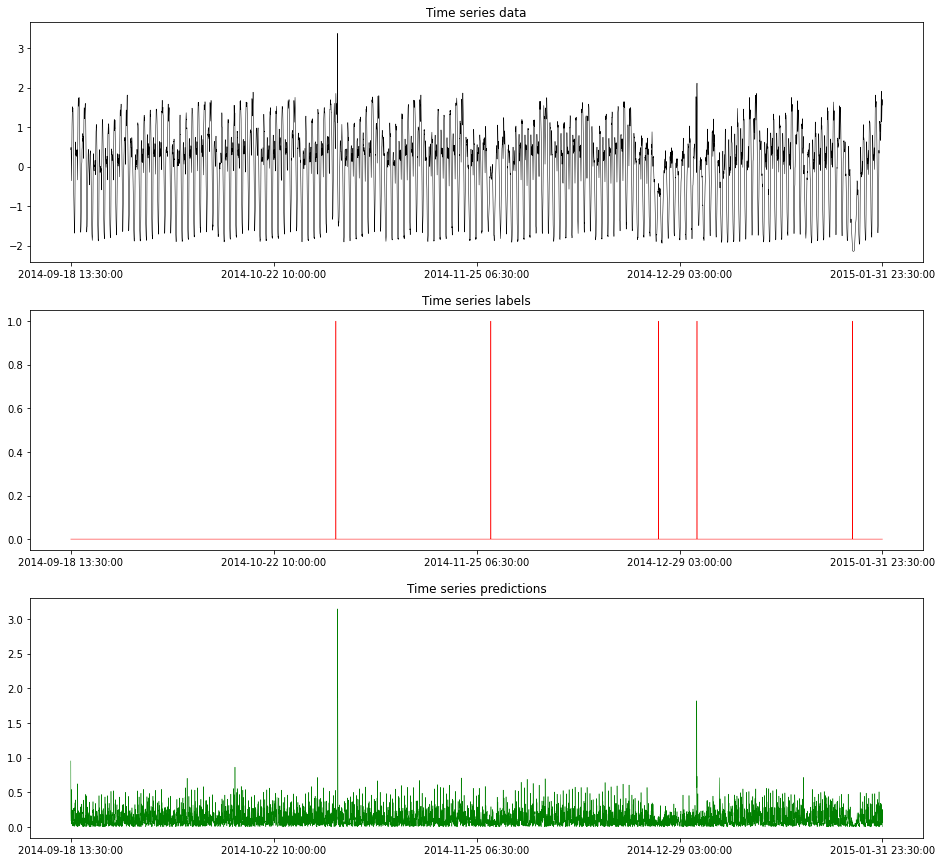

In [12]:
vw.plot_univariate_time_series_predictions(dataframe, scores)

# Anomalies predictions as red dots

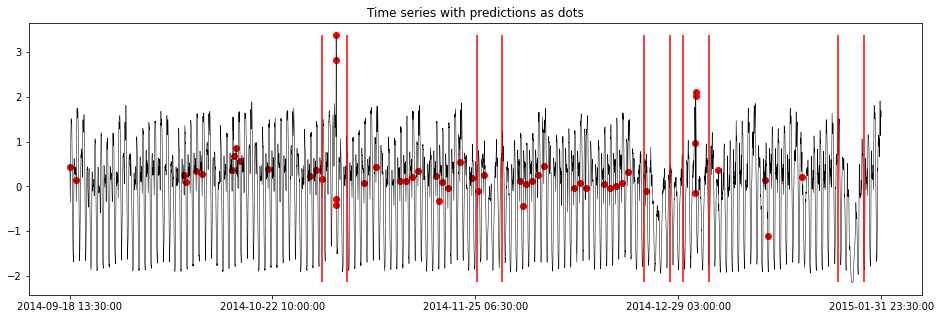

In [13]:
bars = vw.get_bars_indices_on_test_df(all_df,
                                      dataframe,
                                      PURE_DATA_KEY,
                                      GROUND_WINDOWS_PATH)
vw.plot_time_series_with_predicitons_bars(dataframe,
                                          labels,
                                          bars,
                                          pred_color='r')